In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/shared/MouseBrainAtlas/utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-pack

Setting environment for AWS compute node


No vtk


# Global

Directly using local is sufficient

In [3]:
# stack_fixed = 'LM30'
# stack_fixed = 'LM30new'
# stack_fixed = 'LM40'
# stack_fixed = 'LM40new'
# stack_fixed = 'LM31'
# stack_fixed = 'LM38'
stack_fixed = 'LM48'

stack_moving = 'atlasV5'

In [4]:
warp_setting = 24
# warp_setting = 16
# Adding surr is essential.

In [5]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [6]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
    
print surround_weight, include_surround

upstream_warp_id                                                               None
transform_type                                                               affine
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                      2000
std_ty_um                                                                      2000
std_tz_um                                                                      2000
std_theta_xy_degree                                                              30
surround_weight                                                             inverse
regularization_weight                                                           NaN
comment                           global reg with surr no grid search; count

In [7]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
# MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [8]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
#                                                       include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


(356, 427, 375)


Volume shape: (356, 427, 375)


In [9]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])

print volume_fixed[1].shape

(171, 133, 186)


Prior structure/index map not found. Generating a new one.
Volume shape: (171, 133, 186)


In [10]:
structure_subset = all_known_structures_sided

In [11]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [12]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [13]:
label_mapping_m2f

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [14]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [15]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [16]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [17]:
label_weights_m

{1: 1.0,
 2: 0.08578068878090006,
 3: 1.0,
 4: 0.15379052789032086,
 5: 1.0,
 6: 0.40870655618253604}

In [18]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [25]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['3N_L']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [  94.00685547  151.00359631  176.50280962], centroid_f: [ 101.97975633   32.61180881  153.97582006]


In [26]:
aligner.set_label_weights(label_weights=label_weights_m)

In [27]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [28]:
gradient_filepath_map_f

{1: '/shared/CSHL_volumes/LM48/LM48_down32_annotationAsScoreVolume/score_volume_gradients/LM48_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/shared/CSHL_volumes/LM48/LM48_down32_annotationAsScoreVolume/score_volume_gradients/LM48_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/shared/CSHL_volumes/LM48/LM48_down32_annotationAsScoreVolume/score_volume_gradients/LM48_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/shared/CSHL_volumes/LM48/LM48_down32_annotationAsScoreVolume/score_volume_gradients/LM48_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/shared/CSHL_volumes/LM48/LM48_down32_annotationAsScoreVolume/score_volume_gradients/LM48_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/shared/CSHL_volumes/LM48/LM48_down32_annotationAsScoreVolume/score_volume_gradients/LM48_down32_annotationAsScoreVolume_SNR_L_surround_200_%(suffix)s.bp'}

In [29]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.073754 seconds
load gradient 2: 0.073481 seconds
load gradient 3: 0.075031 seconds
load gradient 4: 0.076532 seconds
load gradient 5: 0.076270 seconds
load gradient 6: 0.078550 seconds
overall: 0.454051 seconds


In [30]:
# aligner.grid_search(10)

In [31]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=lr2,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
in T: 0.00 0.00 0.00, out T: 10.00 10.00 -10.00
step: 0.07 seconds
current score: -0.670856
new_T: [10. 10. -10.]
det: 1.10

iteration 1
in T: 10.00 10.00 -10.00, out T: 2.61 4.27 -1.57
step: 0.07 seconds
current score: -0.674581
new_T: [ 2.61382746  4.27167278 -1.57402242]
det: 1.09

iteration 2
in T: 2.61 4.27 -1.57, out T: -0.28 -0.78 3.36
step: 0.07 seconds
current score: -0.669125
new_T: [-0.28451272 -0.78186386  3.35713508]
det: 1.03

iteration 3
in T: -0.28 -0.78 3.36, out T: 3.09 5.06 -3.82
step: 0.07 seconds
current score: -0.670347
new_T: [ 3.08509326  5.06230221 -3.82093112]
det: 1.11

iteration 4
in T: 3.09 5.06 -3.82, out T: -3.71 -1.30 2.57
step: 0.07 seconds
current score: -0.671137
new_T: [-3.71331428 -1.29626664  2.56752676]
det: 1.06

iteration 5
in T: -3.71 -1.30 2.57, out T: 1.07 2.47 -1.58
step: 0.07 seconds
current score: -0.670644
new_T: [ 1.07301845  2.46682315 -1.58389067]
det: 1.10

iteration 6
in T: 1.07 2.47 -1.58, out T: -1.16 -0.75 2.49
step: 

in T: -0.58 0.21 0.50, out T: 0.28 0.62 0.25
step: 0.08 seconds
current score: -0.668910
new_T: [ 0.27505724  0.62360147  0.2452815 ]
det: 1.09

iteration 54
in T: 0.28 0.62 0.25, out T: -0.39 0.52 0.10
step: 0.07 seconds
current score: -0.668876
new_T: [-0.39355575  0.52323302  0.10078987]
det: 1.10

iteration 55
in T: -0.39 0.52 0.10, out T: 0.39 0.95 -0.13
step: 0.07 seconds
current score: -0.668804
new_T: [ 0.39404945  0.94756347 -0.12757243]
det: 1.11

iteration 56
in T: 0.39 0.95 -0.13, out T: -0.63 0.09 0.15
step: 0.07 seconds
current score: -0.668946
new_T: [-0.62968315  0.09227235  0.15122026]
det: 1.10

iteration 57
in T: -0.63 0.09 0.15, out T: -0.26 0.37 -0.38
step: 0.07 seconds
current score: -0.668922
new_T: [-0.25618367  0.36773146 -0.37588597]
det: 1.11

iteration 58
in T: -0.26 0.37 -0.38, out T: -0.42 0.31 0.21
step: 0.07 seconds
current score: -0.668928
new_T: [-0.41836646  0.31273021  0.20702989]
det: 1.11

iteration 59
in T: -0.42 0.31 0.21, out T: -0.23 0.61 -0.03

in T: -0.48 0.96 0.06, out T: -0.51 0.89 0.12
step: 0.07 seconds
current score: -0.668990
new_T: [-0.509465    0.88710499  0.11712631]
det: 1.14

iteration 108
in T: -0.51 0.89 0.12, out T: -0.32 0.83 0.17
step: 0.07 seconds
current score: -0.669107
new_T: [-0.32421154  0.83331294  0.16559915]
det: 1.14

iteration 109
in T: -0.32 0.83 0.17, out T: -0.32 0.78 0.73
step: 0.07 seconds
current score: -0.668948
new_T: [-0.31861789  0.77786005  0.7272685 ]
det: 1.13

iteration 110
in T: -0.32 0.78 0.73, out T: -0.19 0.86 0.07
step: 0.07 seconds
current score: -0.669081
new_T: [-0.19308394  0.86423914  0.06559768]
det: 1.14

iteration 111
in T: -0.19 0.86 0.07, out T: -0.62 0.18 0.38
step: 0.07 seconds
current score: -0.668873
new_T: [-0.62459277  0.17570237  0.37981406]
det: 1.13

iteration 112
in T: -0.62 0.18 0.38, out T: 0.10 0.78 0.10
step: 0.07 seconds
current score: -0.668987
new_T: [ 0.09978533  0.77743243  0.10462883]
det: 1.14

iteration 113
in T: 0.10 0.78 0.10, out T: -0.82 0.50 0

in T: -0.82 0.45 0.07, out T: -0.33 0.94 -0.04
step: 0.08 seconds
current score: -0.668950
new_T: [-0.33226183  0.94359081 -0.04311819]
det: 1.14

iteration 159
in T: -0.33 0.94 -0.04, out T: -0.89 0.53 -0.01
step: 0.08 seconds
current score: -0.669029
new_T: [-0.89441841  0.53209147 -0.01399594]
det: 1.14

iteration 160
in T: -0.89 0.53 -0.01, out T: -0.82 1.01 -0.29
step: 0.08 seconds
current score: -0.668962
new_T: [-0.82091728  1.00934039 -0.29452683]
det: 1.15

iteration 161
in T: -0.82 1.01 -0.29, out T: -0.85 0.24 -0.01
step: 0.07 seconds
current score: -0.669083
new_T: [-0.85224612  0.2439276  -0.01337427]
det: 1.14

iteration 162
in T: -0.85 0.24 -0.01, out T: -0.29 0.77 0.35
step: 0.07 seconds
current score: -0.669004
new_T: [-0.28983047  0.77426678  0.34642651]
det: 1.14

iteration 163
in T: -0.29 0.77 0.35, out T: -1.26 0.68 -0.03
step: 0.07 seconds
current score: -0.668972
new_T: [-1.25927203  0.67549381 -0.0337835 ]
det: 1.15

iteration 164
in T: -1.26 0.68 -0.03, out T: 

in T: -0.26 0.62 0.14, out T: -0.20 0.60 -0.35
step: 0.07 seconds
current score: -0.669156
new_T: [-0.19863966  0.59896493 -0.34569557]
det: 1.18

iteration 210
in T: -0.20 0.60 -0.35, out T: -0.81 0.51 0.21
step: 0.07 seconds
current score: -0.669016
new_T: [-0.80528366  0.51076456  0.20941079]
det: 1.18

iteration 211
in T: -0.81 0.51 0.21, out T: -0.52 0.83 -0.14
step: 0.07 seconds
current score: -0.669165
new_T: [-0.52496416  0.8328349  -0.14246695]
det: 1.19

iteration 212
in T: -0.52 0.83 -0.14, out T: -0.41 0.29 0.44
step: 0.07 seconds
current score: -0.669175
new_T: [-0.40818057  0.28711959  0.44418212]
det: 1.17

iteration 213
in T: -0.41 0.29 0.44, out T: -0.32 0.56 0.40
step: 0.07 seconds
current score: -0.669143
new_T: [-0.32337815  0.55674642  0.40287468]
det: 1.17

iteration 214
in T: -0.32 0.56 0.40, out T: -0.66 0.36 0.05
step: 0.07 seconds
current score: -0.669034
new_T: [-0.65665151  0.36326151  0.05444883]
det: 1.17

iteration 215
in T: -0.66 0.36 0.05, out T: -0.77 

in T: -0.66 0.60 -0.14, out T: -1.08 0.88 -0.14
step: 0.07 seconds
current score: -0.669148
new_T: [-1.07916666  0.87665326 -0.13961008]
det: 1.18

iteration 261
in T: -1.08 0.88 -0.14, out T: -0.89 1.39 0.13
step: 0.07 seconds
current score: -0.669051
new_T: [-0.88712041  1.387082    0.12814363]
det: 1.19

iteration 262
in T: -0.89 1.39 0.13, out T: -0.89 1.13 0.11
step: 0.07 seconds
current score: -0.669086
new_T: [-0.89103749  1.12589267  0.11485112]
det: 1.19

iteration 263
in T: -0.89 1.13 0.11, out T: -0.91 0.87 0.44
step: 0.07 seconds
current score: -0.669109
new_T: [-0.90852489  0.87378227  0.44203848]
det: 1.19

iteration 264
in T: -0.91 0.87 0.44, out T: -0.55 0.66 -0.18
step: 0.07 seconds
current score: -0.669144
new_T: [-0.55230808  0.66006043 -0.17740154]
det: 1.20

iteration 265
in T: -0.55 0.66 -0.18, out T: -0.25 1.09 -0.43
step: 0.07 seconds
current score: -0.669238
new_T: [-0.25301203  1.09389398 -0.43228124]
det: 1.20

iteration 266
in T: -0.25 1.09 -0.43, out T: -0.

in T: -0.99 0.81 -0.03, out T: -1.13 0.53 -0.03
step: 0.07 seconds
current score: -0.669240
new_T: [-1.12510598  0.53385994 -0.03168631]
det: 1.19

iteration 312
in T: -1.13 0.53 -0.03, out T: -0.81 0.56 -0.23
step: 0.07 seconds
current score: -0.669116
new_T: [-0.80989336  0.5582136  -0.22589869]
det: 1.19

iteration 313
in T: -0.81 0.56 -0.23, out T: -0.89 0.63 -0.07
step: 0.07 seconds
current score: -0.669219
new_T: [-0.88721388  0.6322842  -0.07459295]
det: 1.19

iteration 314
in T: -0.89 0.63 -0.07, out T: -0.63 0.81 0.09
step: 0.07 seconds
current score: -0.669074
new_T: [-0.63125666  0.81058961  0.08597223]
det: 1.20

iteration 315
in T: -0.63 0.81 0.09, out T: -0.84 0.85 0.31
step: 0.07 seconds
current score: -0.669290
new_T: [-0.83944687  0.85050097  0.3087363 ]
det: 1.20

iteration 316
in T: -0.84 0.85 0.31, out T: -0.53 0.96 0.08
step: 0.07 seconds
current score: -0.669195
new_T: [-0.52620438  0.958331    0.08406841]
det: 1.20

iteration 317
in T: -0.53 0.96 0.08, out T: -0.

in T: -0.58 0.46 -0.13, out T: -0.67 0.18 -0.11
step: 0.07 seconds
current score: -0.669186
new_T: [-0.66833375  0.17971635 -0.11123886]
det: 1.20

iteration 363
in T: -0.67 0.18 -0.11, out T: -0.08 0.68 -0.08
step: 0.07 seconds
current score: -0.669175
new_T: [-0.08364635  0.68264768 -0.07986795]
det: 1.21

iteration 364
in T: -0.08 0.68 -0.08, out T: -0.88 0.86 0.28
step: 0.07 seconds
current score: -0.669264
new_T: [-0.87671208  0.8567564   0.2805978 ]
det: 1.21

iteration 365
in T: -0.88 0.86 0.28, out T: -0.40 0.47 0.24
step: 0.07 seconds
current score: -0.669197
new_T: [-0.39789371  0.47191411  0.24230587]
det: 1.20

iteration 366
in T: -0.40 0.47 0.24, out T: -0.26 0.73 -0.21
step: 0.07 seconds
current score: -0.669112
new_T: [-0.2622448   0.73160599 -0.20680509]
det: 1.20

iteration 367
in T: -0.26 0.73 -0.21, out T: -0.51 0.73 -0.04
step: 0.07 seconds
current score: -0.669220
new_T: [-0.50861977  0.7279616  -0.04240436]
det: 1.20

iteration 368
in T: -0.51 0.73 -0.04, out T: -

in T: -0.32 0.67 -0.32, out T: -0.12 0.41 -0.11
step: 0.07 seconds
current score: -0.669236
new_T: [-0.11717292  0.4050895  -0.11000921]
det: 1.22

iteration 417
in T: -0.12 0.41 -0.11, out T: 0.10 0.47 0.04
step: 0.07 seconds
current score: -0.669183
new_T: [ 0.10487133  0.47326598  0.04210277]
det: 1.21

iteration 418
in T: 0.10 0.47 0.04, out T: 0.11 0.53 0.38
step: 0.07 seconds
current score: -0.669261
new_T: [ 0.11091318  0.52994172  0.38426455]
det: 1.21

iteration 419
in T: 0.11 0.53 0.38, out T: -0.20 0.66 0.01
step: 0.07 seconds
current score: -0.669241
new_T: [-0.20186344  0.6587674   0.01146428]
det: 1.22

iteration 420
in T: -0.20 0.66 0.01, out T: -0.23 0.52 -0.07
step: 0.07 seconds
current score: -0.669338
new_T: [-0.23349092  0.52241686 -0.06812408]
det: 1.22

iteration 421
in T: -0.23 0.52 -0.07, out T: 0.15 0.84 -0.06
step: 0.07 seconds
current score: -0.669229
new_T: [ 0.15207819  0.84369789 -0.05917177]
det: 1.22

iteration 422
in T: 0.15 0.84 -0.06, out T: -0.51 0.4

in T: -0.39 0.64 -0.23, out T: -0.08 0.31 0.04
step: 0.07 seconds
current score: -0.669271
new_T: [-0.0796774   0.31459967  0.04013484]
det: 1.22

iteration 468
in T: -0.08 0.31 0.04, out T: -0.48 0.17 -0.43
step: 0.07 seconds
current score: -0.669283
new_T: [-0.4756921   0.16867083 -0.4297514 ]
det: 1.22

iteration 469
in T: -0.48 0.17 -0.43, out T: -0.58 0.11 -0.11
step: 0.07 seconds
current score: -0.669232
new_T: [-0.58170784  0.11128187 -0.11312191]
det: 1.22

iteration 470
in T: -0.58 0.11 -0.11, out T: -0.39 0.42 0.02
step: 0.07 seconds
current score: -0.669232
new_T: [-0.3877764   0.42090301  0.02160832]
det: 1.22

iteration 471
in T: -0.39 0.42 0.02, out T: -0.62 0.21 0.01
step: 0.07 seconds
current score: -0.669294
new_T: [-0.61894713  0.21077807  0.00643341]
det: 1.21

iteration 472
in T: -0.62 0.21 0.01, out T: -0.66 0.52 -0.09
step: 0.07 seconds
current score: -0.669235
new_T: [-0.66454322  0.51581044 -0.09490653]
det: 1.22

iteration 473
in T: -0.66 0.52 -0.09, out T: -0.

in T: -0.80 0.90 -0.14, out T: -0.36 0.98 -0.29
step: 0.07 seconds
current score: -0.669415
new_T: [-0.35616073  0.97727277 -0.29008949]
det: 1.23

iteration 519
in T: -0.36 0.98 -0.29, out T: -1.37 0.69 -0.15
step: 0.07 seconds
current score: -0.669275
new_T: [-1.36951426  0.6918707  -0.14522344]
det: 1.23

iteration 520
in T: -1.37 0.69 -0.15, out T: -1.73 0.72 -0.17
step: 0.07 seconds
current score: -0.669417
new_T: [-1.72606386  0.71550507 -0.16582959]
det: 1.24

iteration 521
in T: -1.73 0.72 -0.17, out T: -1.45 0.76 -0.44
step: 0.07 seconds
current score: -0.669444
new_T: [-1.45493635  0.76429891 -0.44215837]
det: 1.24

iteration 522
in T: -1.45 0.76 -0.44, out T: -1.10 0.72 -0.04
step: 0.07 seconds
current score: -0.669329
new_T: [-1.10166475  0.71640819 -0.04461043]
det: 1.23

iteration 523
in T: -1.10 0.72 -0.04, out T: -1.15 0.75 -0.01
step: 0.07 seconds
current score: -0.669273
new_T: [-1.15473702  0.74539471 -0.01203942]
det: 1.23

iteration 524
in T: -1.15 0.75 -0.01, out 

in T: -0.70 0.53 0.06, out T: -0.66 0.42 0.47
step: 0.07 seconds
current score: -0.669312
new_T: [-0.66434545  0.4171524   0.47250277]
det: 1.23

iteration 570
in T: -0.66 0.42 0.47, out T: -0.92 0.78 0.39
step: 0.07 seconds
current score: -0.669387
new_T: [-0.91649776  0.7789065   0.39360608]
det: 1.24

iteration 571
in T: -0.92 0.78 0.39, out T: -1.02 0.74 -0.11
step: 0.07 seconds
current score: -0.669277
new_T: [-1.01800544  0.73770214 -0.10633419]
det: 1.24

iteration 572
in T: -1.02 0.74 -0.11, out T: -1.16 0.80 -0.20
step: 0.07 seconds
current score: -0.669334
new_T: [-1.16444201  0.79695648 -0.20286101]
det: 1.24

iteration 573
in T: -1.16 0.80 -0.20, out T: -1.19 0.78 -0.08
step: 0.07 seconds
current score: -0.669376
new_T: [-1.18726411  0.78276827 -0.07505463]
det: 1.24

iteration 574
in T: -1.19 0.78 -0.08, out T: -0.74 0.92 -0.10
step: 0.07 seconds
current score: -0.669379
new_T: [-0.74023361  0.91627319 -0.10431097]
det: 1.24

iteration 575
in T: -0.74 0.92 -0.10, out T: -0

in T: 0.36 0.39 -0.40, out T: -0.09 0.31 -0.35
step: 0.07 seconds
current score: -0.669375
new_T: [-0.08915944  0.31346162 -0.34806873]
det: 1.25

iteration 621
in T: -0.09 0.31 -0.35, out T: -0.19 0.74 -0.28
step: 0.07 seconds
current score: -0.669416
new_T: [-0.18974456  0.74432698 -0.2805775 ]
det: 1.26

iteration 622
in T: -0.19 0.74 -0.28, out T: -0.28 0.73 -0.19
step: 0.07 seconds
current score: -0.669293
new_T: [-0.27860233  0.72543433 -0.19250711]
det: 1.26

iteration 623
in T: -0.28 0.73 -0.19, out T: -0.35 0.97 -0.08
step: 0.07 seconds
current score: -0.669337
new_T: [-0.3469714   0.96641358 -0.08467568]
det: 1.26

iteration 624
in T: -0.35 0.97 -0.08, out T: -0.33 0.63 -0.27
step: 0.07 seconds
current score: -0.669344
new_T: [-0.32790469  0.62674178 -0.27016899]
det: 1.25

iteration 625
in T: -0.33 0.63 -0.27, out T: -0.17 0.72 -0.34
step: 0.07 seconds
current score: -0.669451
new_T: [-0.17447732  0.72470082 -0.34463941]
det: 1.25

iteration 626
in T: -0.17 0.72 -0.34, out T

in T: 0.49 0.44 -0.36, out T: 0.64 0.58 -0.21
step: 0.07 seconds
current score: -0.669449
new_T: [ 0.64196859  0.581623   -0.20546288]
det: 1.25

iteration 675
in T: 0.64 0.58 -0.21, out T: 0.67 0.44 -0.04
step: 0.07 seconds
current score: -0.669375
new_T: [ 0.67140618  0.44429372 -0.03827437]
det: 1.25

iteration 676
in T: 0.67 0.44 -0.04, out T: 0.48 0.50 -0.41
step: 0.07 seconds
current score: -0.669436
new_T: [ 0.47797304  0.5030099  -0.40947903]
det: 1.25

iteration 677
in T: 0.48 0.50 -0.41, out T: 0.32 0.69 -0.25
step: 0.07 seconds
current score: -0.669458
new_T: [ 0.3205519   0.69039706 -0.25351692]
det: 1.25

iteration 678
in T: 0.32 0.69 -0.25, out T: 0.01 0.94 -0.17
step: 0.07 seconds
current score: -0.669432
new_T: [ 0.01442772  0.93711423 -0.16861415]
det: 1.26

iteration 679
in T: 0.01 0.94 -0.17, out T: -0.01 0.81 -0.21
step: 0.07 seconds
current score: -0.669407
new_T: [-0.00711883  0.80660307 -0.20957435]
det: 1.25

iteration 680
in T: -0.01 0.81 -0.21, out T: 0.11 0.6

in T: -0.06 0.86 0.10, out T: -0.45 0.61 -0.13
step: 0.07 seconds
current score: -0.669334
new_T: [-0.45096084  0.61024848 -0.12669371]
det: 1.25

iteration 726
in T: -0.45 0.61 -0.13, out T: -0.93 0.51 -0.06
step: 0.07 seconds
current score: -0.669356
new_T: [-0.93405818  0.50773612 -0.05798792]
det: 1.25

iteration 727
in T: -0.93 0.51 -0.06, out T: -0.16 0.69 -0.32
step: 0.07 seconds
current score: -0.669300
new_T: [-0.15617053  0.69389696 -0.3196748 ]
det: 1.25

iteration 728
in T: -0.16 0.69 -0.32, out T: 0.11 0.53 0.35
step: 0.07 seconds
current score: -0.669371
new_T: [ 0.1112376   0.52619385  0.34794348]
det: 1.23

iteration 729
in T: 0.11 0.53 0.35, out T: 0.33 0.56 0.25
step: 0.07 seconds
current score: -0.669339
new_T: [ 0.32778993  0.55946193  0.25338137]
det: 1.23

iteration 730
in T: 0.33 0.56 0.25, out T: -0.03 0.67 -0.22
step: 0.07 seconds
current score: -0.669365
new_T: [-0.03196168  0.66557487 -0.21584367]
det: 1.24

iteration 731
in T: -0.03 0.67 -0.22, out T: -0.10 

in T: -0.63 0.76 -0.22, out T: -0.50 0.51 -0.01
step: 0.08 seconds
current score: -0.669267
new_T: [-0.50311735  0.51445577 -0.01263463]
det: 1.23

iteration 777
in T: -0.50 0.51 -0.01, out T: -0.42 0.41 -0.24
step: 0.07 seconds
current score: -0.669093
new_T: [-0.42321017  0.41485052 -0.23980131]
det: 1.22

iteration 778
in T: -0.42 0.41 -0.24, out T: -0.12 0.60 -0.47
step: 0.07 seconds
current score: -0.669247
new_T: [-0.11805176  0.60162122 -0.47337365]
det: 1.23

iteration 779
in T: -0.12 0.60 -0.47, out T: -0.36 0.74 -0.20
step: 0.07 seconds
current score: -0.669170
new_T: [-0.3566916   0.73527949 -0.19769077]
det: 1.23

iteration 780
in T: -0.36 0.74 -0.20, out T: -0.44 0.62 -0.30
step: 0.07 seconds
current score: -0.669174
new_T: [-0.44332265  0.62344244 -0.30388176]
det: 1.23

iteration 781
in T: -0.44 0.62 -0.30, out T: -0.51 0.67 -0.10
step: 0.07 seconds
current score: -0.669269
new_T: [-0.51296517  0.67338738 -0.1013127 ]
det: 1.23

iteration 782
in T: -0.51 0.67 -0.10, out 

in T: -0.54 0.70 -0.38, out T: -1.00 0.46 -0.05
step: 0.07 seconds
current score: -0.669152
new_T: [-0.99852868  0.45997148 -0.05194542]
det: 1.23

iteration 828
in T: -1.00 0.46 -0.05, out T: -0.62 0.74 -0.19
step: 0.07 seconds
current score: -0.669271
new_T: [-0.62052436  0.74465235 -0.19418192]
det: 1.23

iteration 829
in T: -0.62 0.74 -0.19, out T: -0.82 0.43 0.09
step: 0.07 seconds
current score: -0.669150
new_T: [-0.82374354  0.43378389  0.08749899]
det: 1.22

iteration 830
in T: -0.82 0.43 0.09, out T: -1.11 0.52 0.06
step: 0.07 seconds
current score: -0.669209
new_T: [-1.10811051  0.51585644  0.06262827]
det: 1.23

iteration 831
in T: -1.11 0.52 0.06, out T: -1.07 0.74 -0.20
step: 0.07 seconds
current score: -0.669230
new_T: [-1.06765459  0.74388431 -0.20315103]
det: 1.23

iteration 832
in T: -1.07 0.74 -0.20, out T: -1.27 0.51 -0.01
step: 0.07 seconds
current score: -0.669214
new_T: [-1.27456797  0.51088514 -0.01339376]
det: 1.23

iteration 833
in T: -1.27 0.51 -0.01, out T: -

in T: 0.11 1.25 0.18, out T: -0.47 0.94 0.05
step: 0.07 seconds
current score: -0.669125
new_T: [-0.46971547  0.94483508  0.04822618]
det: 1.23

iteration 879
in T: -0.47 0.94 0.05, out T: -0.28 0.97 0.00
step: 0.07 seconds
current score: -0.669251
new_T: [-0.28383548  0.96676978  0.0036519 ]
det: 1.23

iteration 880
in T: -0.28 0.97 0.00, out T: -0.08 0.59 -0.33
step: 0.07 seconds
current score: -0.669275
new_T: [-0.08195014  0.59493802 -0.33214996]
det: 1.23

iteration 881
in T: -0.08 0.59 -0.33, out T: -0.26 0.71 0.03
step: 0.07 seconds
current score: -0.669209
new_T: [-0.26237976  0.70734828  0.02737405]
det: 1.23

iteration 882
in T: -0.26 0.71 0.03, out T: -0.40 0.73 0.12
step: 0.07 seconds
current score: -0.669199
new_T: [-0.40390162  0.73381958  0.11525322]
det: 1.24

iteration 883
in T: -0.40 0.73 0.12, out T: -0.73 0.54 -0.04
step: 0.07 seconds
current score: -0.669275
new_T: [-0.72691762  0.54180577 -0.04299488]
det: 1.24

iteration 884
in T: -0.73 0.54 -0.04, out T: -0.43 0

in T: 0.32 0.91 -0.09, out T: 0.77 0.84 -0.20
step: 0.07 seconds
current score: -0.669311
new_T: [ 0.77103286  0.84270256 -0.20173753]
det: 1.25

iteration 933
in T: 0.77 0.84 -0.20, out T: 0.32 0.72 0.02
step: 0.07 seconds
current score: -0.669343
new_T: [ 0.31935701  0.71837671  0.01673392]
det: 1.25

iteration 934
in T: 0.32 0.72 0.02, out T: 0.41 0.77 0.05
step: 0.07 seconds
current score: -0.669220
new_T: [ 0.4078819   0.76720847  0.0495374 ]
det: 1.25

iteration 935
in T: 0.41 0.77 0.05, out T: 0.31 1.06 -0.13
step: 0.07 seconds
current score: -0.669300
new_T: [ 0.30544977  1.05967964 -0.13145265]
det: 1.25

iteration 936
in T: 0.31 1.06 -0.13, out T: 0.26 0.77 0.09
step: 0.07 seconds
current score: -0.669339
new_T: [ 0.26132312  0.77120471  0.08867679]
det: 1.25

iteration 937
in T: 0.26 0.77 0.09, out T: 0.26 0.70 -0.11
step: 0.07 seconds
current score: -0.669338
new_T: [ 0.26201993  0.69938822 -0.10644764]
det: 1.24

iteration 938
in T: 0.26 0.70 -0.11, out T: 0.09 0.78 -0.26


in T: 0.35 0.57 0.14, out T: 0.18 0.63 0.15
step: 0.08 seconds
current score: -0.669278
new_T: [ 0.18306732  0.63171786  0.14695519]
det: 1.26

iteration 987
in T: 0.18 0.63 0.15, out T: 0.42 0.35 0.43
step: 0.07 seconds
current score: -0.669205
new_T: [ 0.42168835  0.34693215  0.4332143 ]
det: 1.25

iteration 988
in T: 0.42 0.35 0.43, out T: 0.32 0.65 -0.04
step: 0.07 seconds
current score: -0.669261
new_T: [ 0.31938652  0.6468751  -0.04286206]
det: 1.25

iteration 989
in T: 0.32 0.65 -0.04, out T: -0.02 0.81 0.07
step: 0.07 seconds
current score: -0.669254
new_T: [-0.02484724  0.81181849  0.07465389]
det: 1.26

iteration 990
in T: -0.02 0.81 0.07, out T: -0.02 0.93 -0.35
step: 0.07 seconds
current score: -0.669246
new_T: [-0.02080321  0.9260715  -0.34703549]
det: 1.27

iteration 991
in T: -0.02 0.93 -0.35, out T: 0.14 0.88 -0.27
step: 0.07 seconds
current score: -0.669292
new_T: [ 0.137855    0.88179693 -0.2666773 ]
det: 1.27

iteration 992
in T: 0.14 0.88 -0.27, out T: 0.27 0.87 -0.

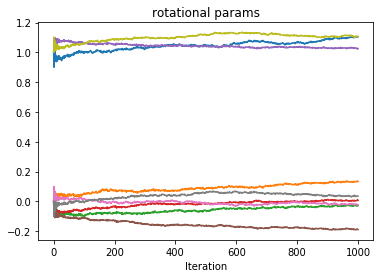

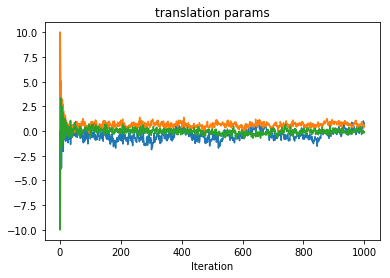

In [32]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.668740424281 -0.669276300631
[[ 0.95368128  0.0507282  -0.08927771  0.43716075]
 [-0.0728064   1.07523394 -0.09785631  0.82928601]
 [ 0.02175034 -0.01901003  1.03182299  0.11033746]]


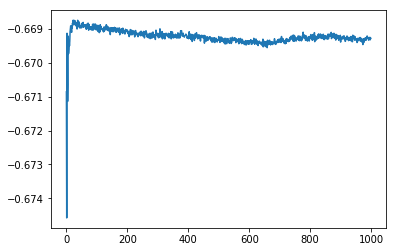

In [33]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [34]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,130,0,1,0,-70,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (grid_search_T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [35]:
structure = 'SNR_L'

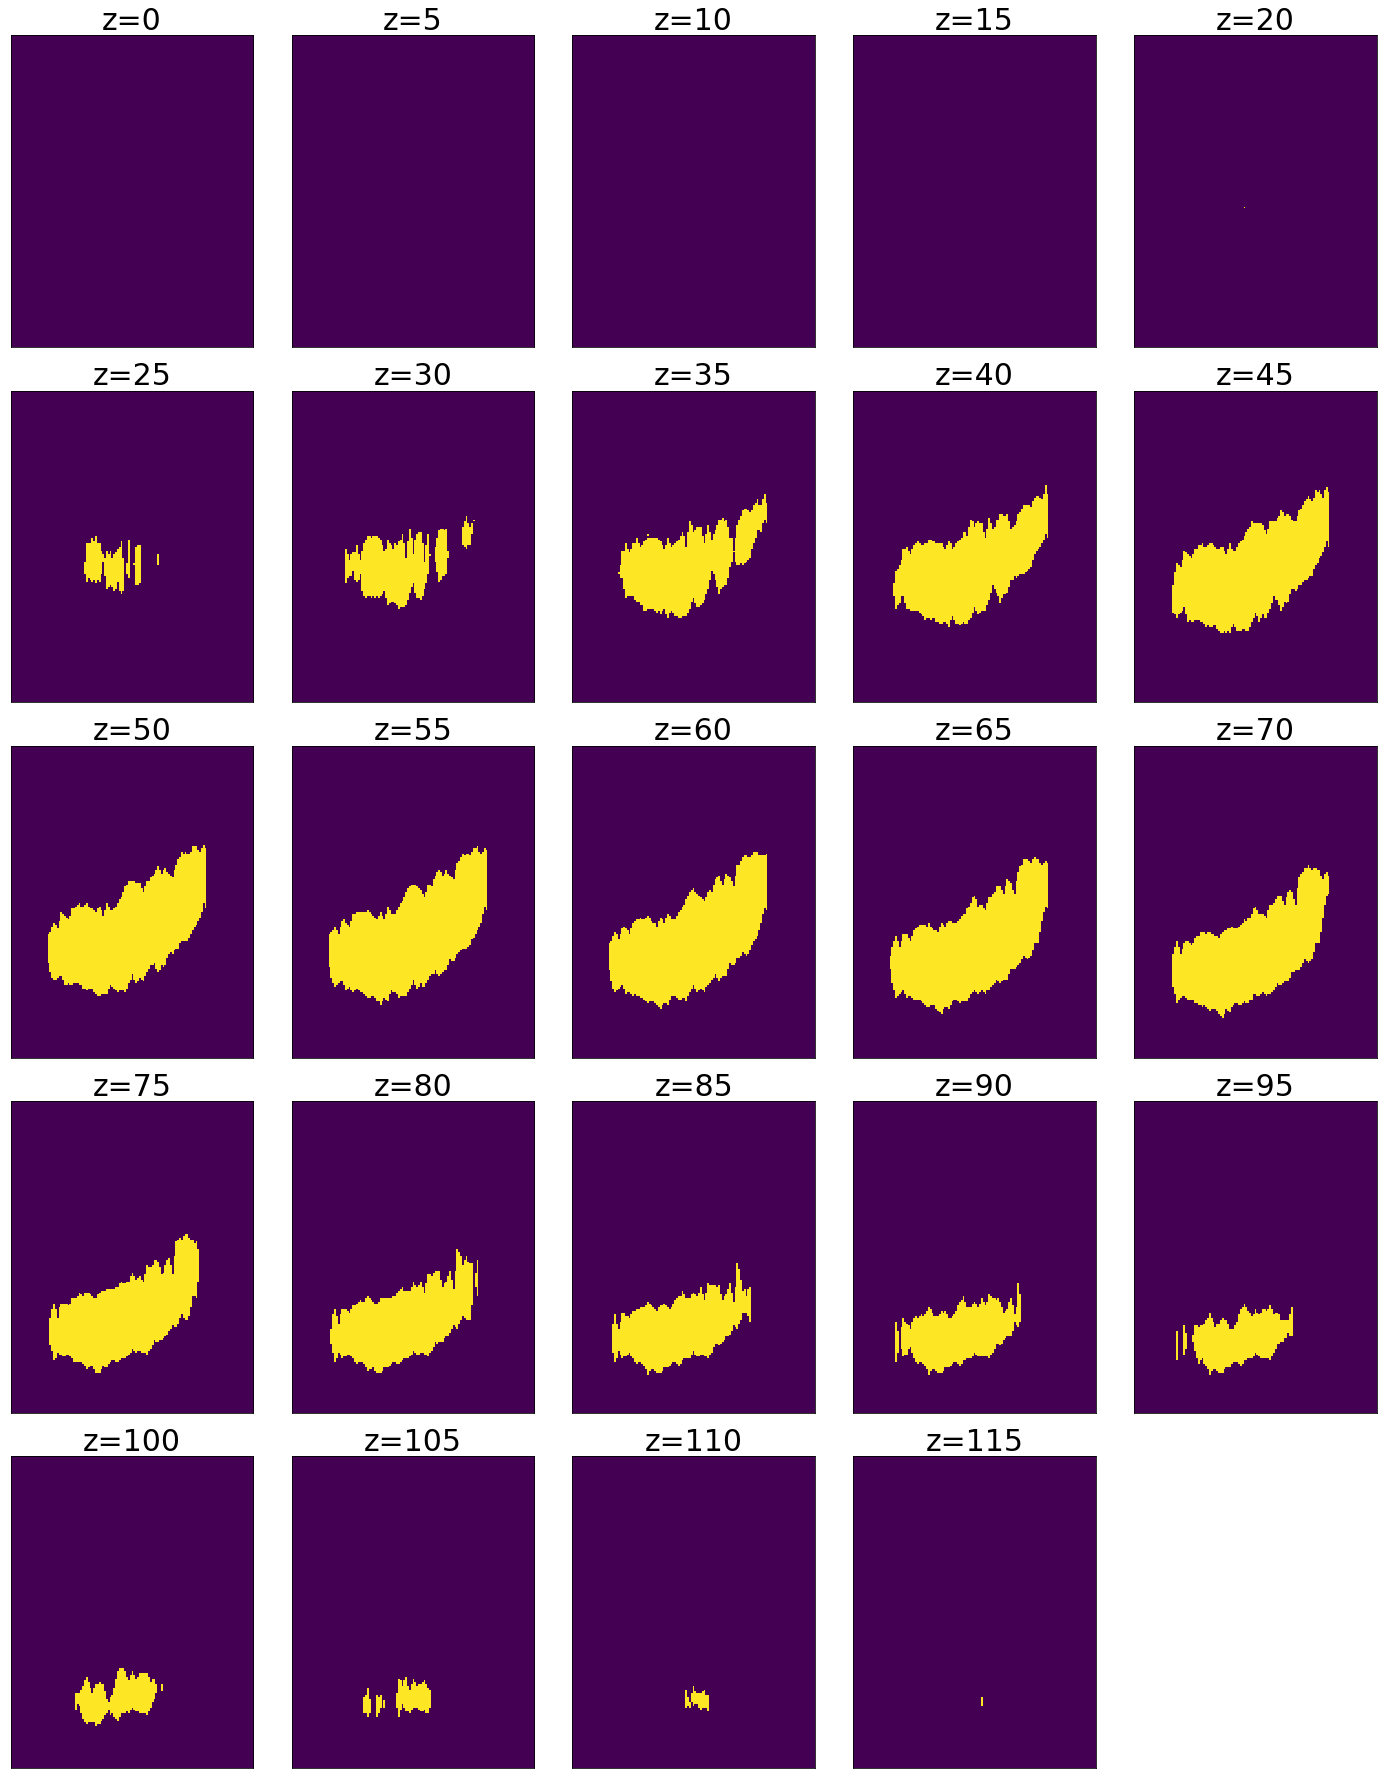

In [36]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [37]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

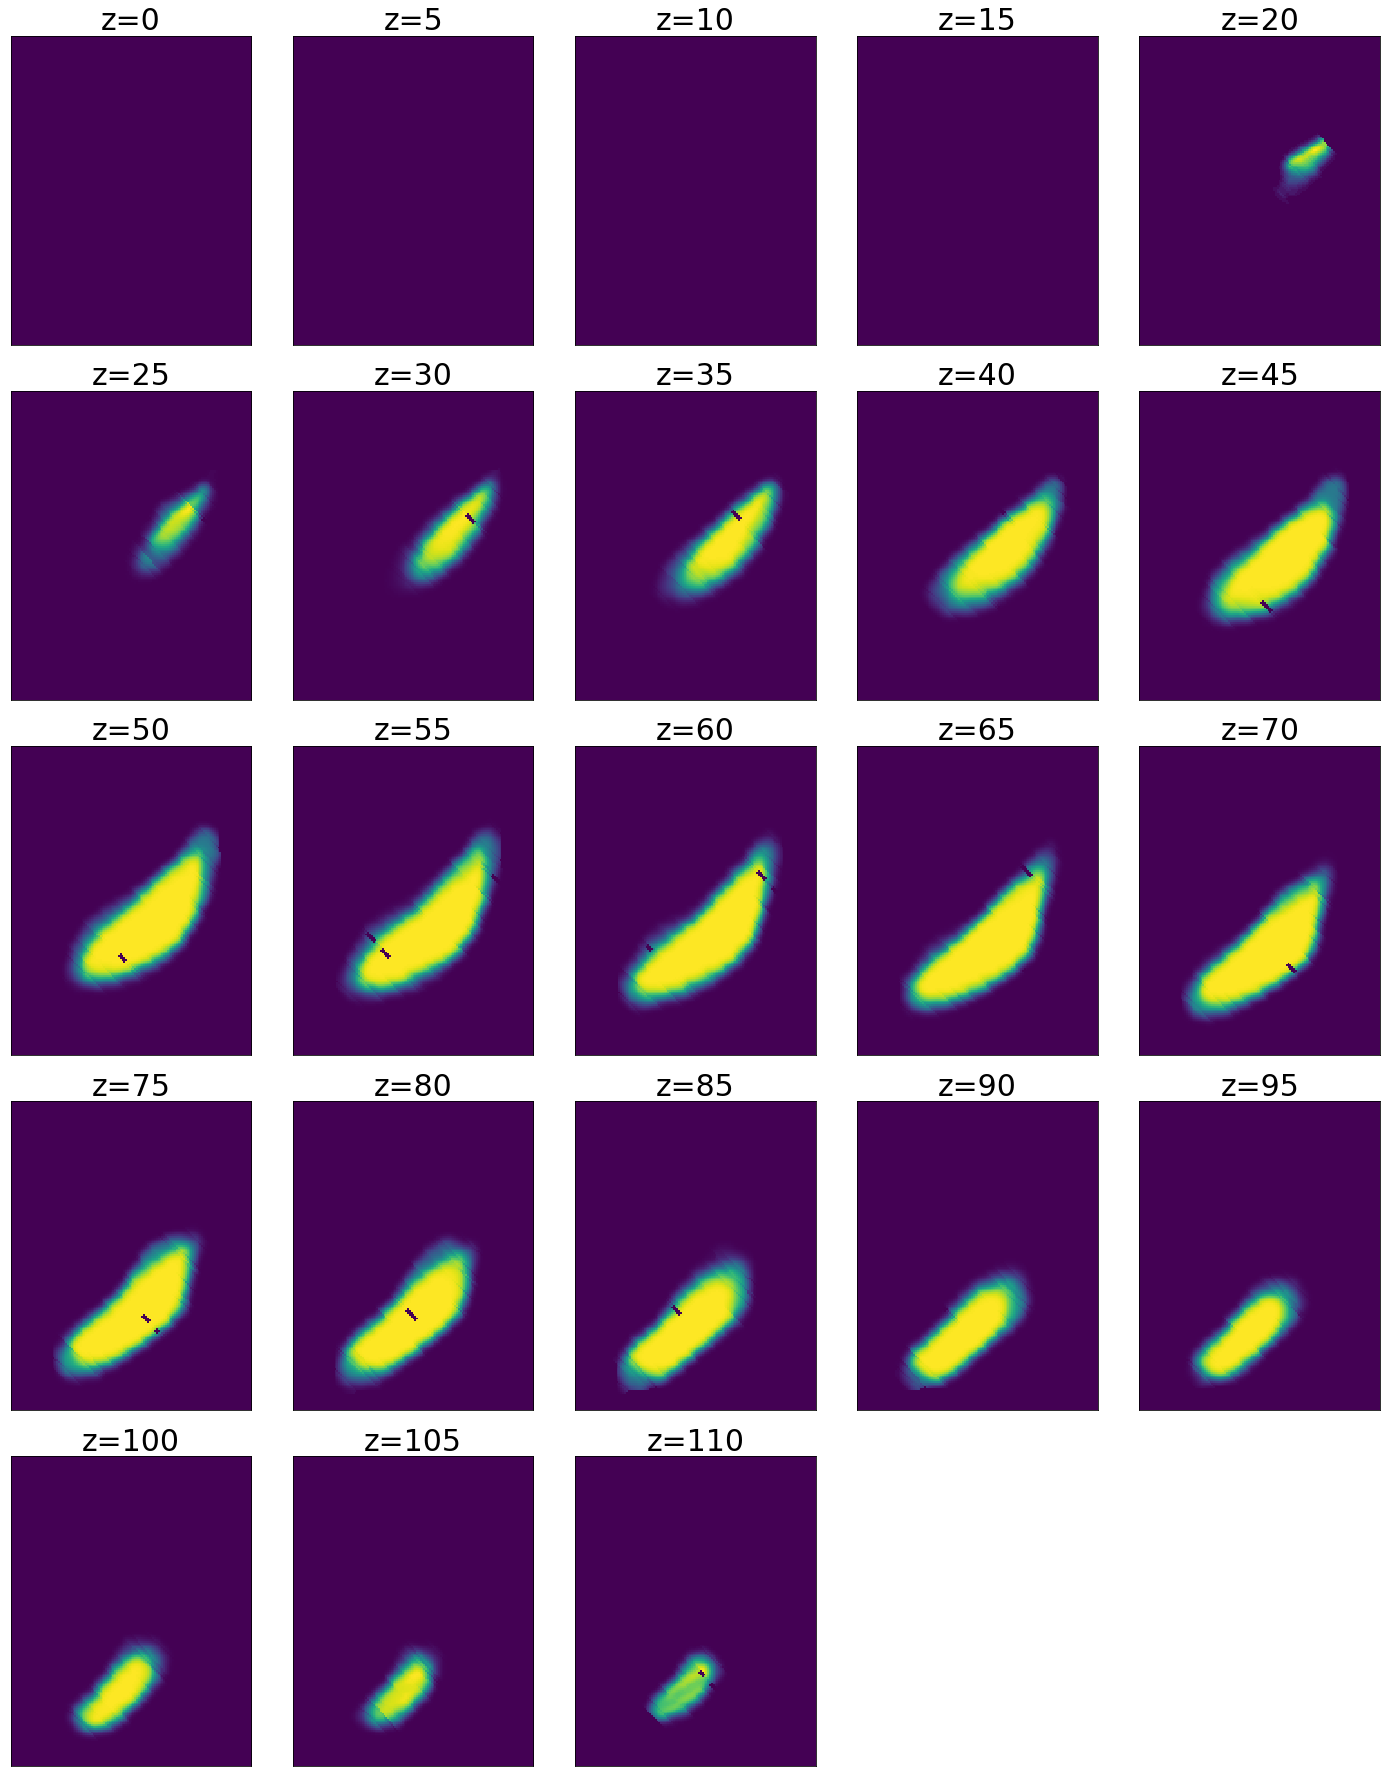

In [38]:
v_m2f = \
crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

display_volume_sections(v_m2f, start_level=0)

In [39]:
# Warping all structures.

volume_m2f = {}
for label_m, vol_m in volume_moving.iteritems():
    
    volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
    transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2f[label_m] = crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                        out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

In [41]:
def draw_alignment(warped_atlas, fixed_volumes, level_spacing=10, zs=None):
    """
    """
    
    ydim_f, xdim_f, zdim_f = fixed_volumes.values()[0].shape
    
    if zs is None:
        zs = np.arange(0, zdim, level_spacing)
            
    for z in zs:
        viz = np.zeros((ydim_f, xdim_f, 3), np.uint8)
        
        for l in volume_fixed.keys():
            if is_surround_label(label_to_structure_fixed[l]): 
                continue
            zslice = volume_fixed[l][..., z]
            contours = find_contour_points(zslice)
            if len(contours) == 0:
                continue
            cnt = contours[1][0].astype(np.int)
            cv2.polylines(viz, pts=[cnt], isClosed=True, 
                          color=name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])])
            
        for l in warped_atlas.keys():
            if is_surround_label(label_to_structure_moving[l]): 
                continue
            zslice = warped_atlas[l][..., z]
            contours = find_contour_points(zslice)
            if len(contours) == 0:
                continue
            cnt = contours[1][0].astype(np.int)
            cv2.polylines(viz, pts=[cnt], isClosed=True,
                         color=name_unsided_to_color[convert_to_original_name(label_to_structure_moving[l])])

        plt.figure(figsize=(10,10));
        plt.imshow(viz)
        plt.title("z=%d" % z)
        plt.show()

In [42]:
def draw_alignment(warped_atlas, fixed_volumes, level_spacing=10, zs=None, ncols=5):
    """
    """
    
    ydim_f, xdim_f, zdim_f = fixed_volumes.values()[0].shape
    
    aspect_ratio = float(xdim_f)/ydim_f # width / height
    
    if zs is None:
        zs = np.arange(0, zdim, level_spacing)
    n = len(zs)

    nrows = int(np.ceil(len(zs) / float(ncols)))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, squeeze=True, 
                             figsize=(ncols*5*aspect_ratio, nrows*5))
    axes = axes.flatten()
    
    for zi in range(len(axes)):
        if zi >= n:
            axes[zi].axis('off');
        else:        
            z = zs[zi]
            viz = np.zeros((ydim_f, xdim_f, 3), np.uint8)

            for l in volume_fixed.keys():
                if is_surround_label(label_to_structure_fixed[l]): 
                    continue
                zslice = volume_fixed[l][..., z]
                contours = find_contour_points(zslice)
                if len(contours) == 0:
                    continue
                cnt = contours[1][0].astype(np.int)
                cv2.polylines(viz, pts=[cnt], isClosed=True, 
                              thickness=1,
                              color=name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])])

            cutoff_level = 0.5

            for l in warped_atlas.keys():
                if is_surround_label(label_to_structure_moving[l]): 
                    continue
                zslice = warped_atlas[l][..., z]
                contours = find_contour_points(zslice > cutoff_level)
                if len(contours) == 0:
                    continue
                cnt = contours[1][0].astype(np.int)
                cv2.polylines(viz, pts=[cnt], isClosed=True,
                              thickness=1,
                             color=name_unsided_to_color[convert_to_original_name(label_to_structure_moving[l])])        

            axes[zi].imshow(viz)
            axes[zi].set_title("z=%d" % z)
            axes[zi].set_xticks([]);
            axes[zi].set_yticks([]);
        
    plt.show()

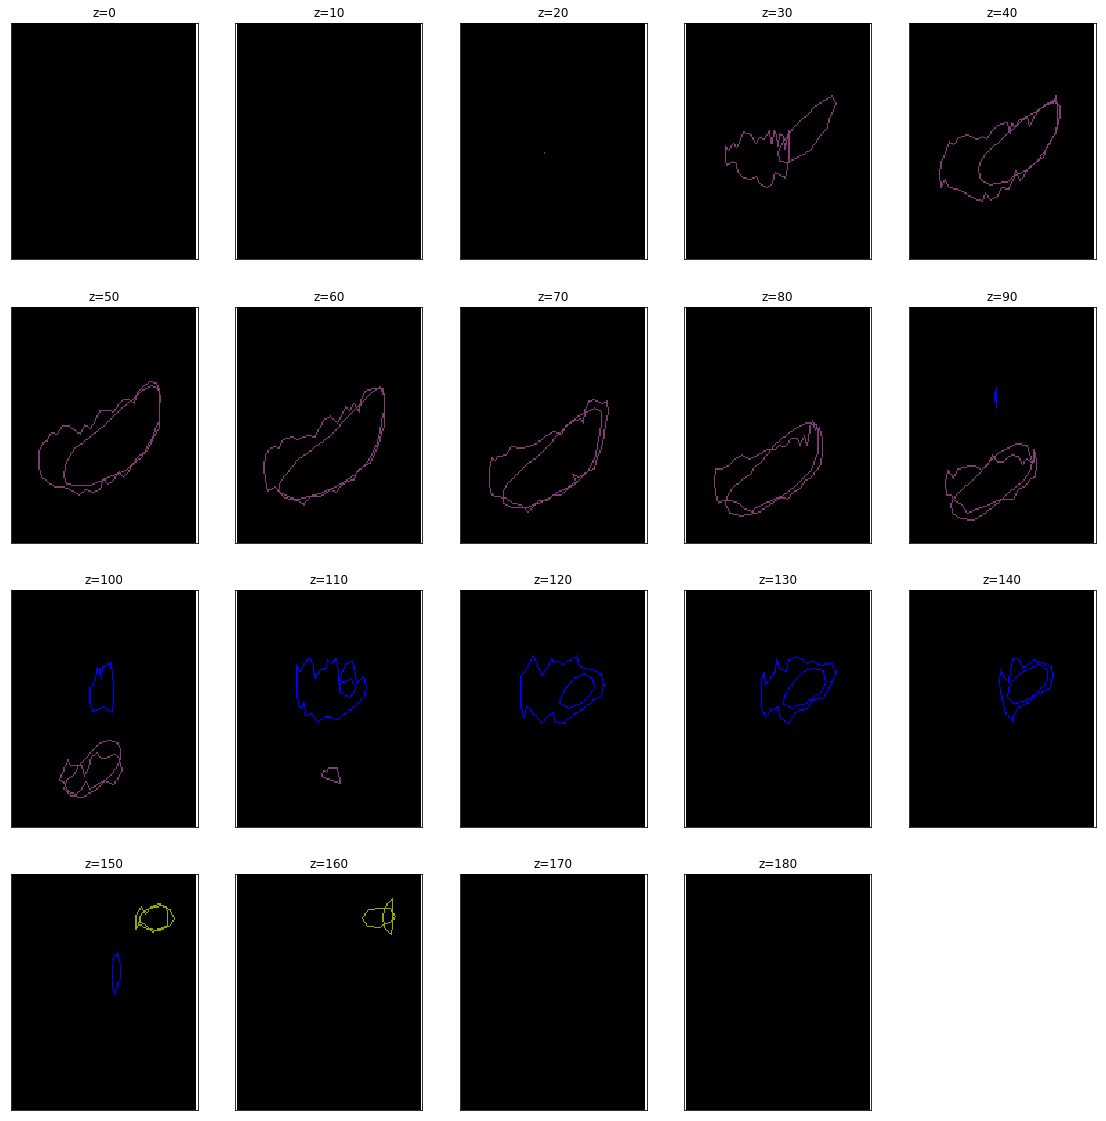

In [43]:
draw_alignment(warped_atlas=volume_m2f, fixed_volumes=volume_fixed, zs=np.arange(0,190,10), ncols=5)

In [31]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

IndexError: index -1 is out of bounds for axis 0 with size 0

# Local

warp setting = 16 means directly rigidly register SNR_L with atlas SNR_L, taking surround into consideration.

In [63]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [64]:
# stack_fixed = 'LM30new'
stack_fixed = 'LM40new'
# stack_fixed = 'LM30'
# stack_fixed = 'LM40'
stack_moving = 'atlasV5'

In [65]:
warp_setting = 22

In [66]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                        None
transform_type                                         rigid
terminate_thresh                                         NaN
grad_computation_sample_number                        100000
grid_search_sample_number                              10000
std_tx_um                                                200
std_ty_um                                                200
std_tz_um                                                200
std_theta_xy_degree                                       30
surround_weight                                      inverse
regularization_weight                                      0
comment                           global reg rigid with surr
max_iter_num                                             NaN
Name: 22, dtype: object

std 13.5869565217 13.5869565217 13.5869565217 0.523598775598
surround inverse
regularization [ 0.  0.  0.]


In [67]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
MAX_GRID_SEARCH_ITER_NUM = 30

In [68]:
lr1 = 10
lr2 = 0.1

In [69]:
structure = 'SNR_L'

In [70]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.
Volume shape: (163, 113, 182)


In [71]:
print DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

[ -19   93 1133 1295 5918 6099]


In [72]:
if include_surround:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')])
else:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                                                 structures=[structure])

# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            # Note that this is positive; in regular, surround is negative
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

Prior structure/index map not found. Generating a new one.
Volume shape: (356, 427, 375)


In [73]:
label_weights_m

{1: 1.0, 2: 0.40870655618253604}

In [74]:
aligner = Aligner4(volume_fixed, volume_moving, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [ 55.11165633  97.61789349  62.03171572]


In [75]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [76]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [79]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([1, 2])
load gradient 1: 0.063736 seconds
load gradient 2: 0.065711 seconds
overall: 0.129571 seconds


In [80]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
step: 0.25 seconds
current score: 0.222423
new_T: [ 0.99993333 -1.00996642  0.98996692]
det: 1.00

iteration 1
step: 0.24 seconds
current score: 0.223749
new_T: [ 1.36760808 -0.59689     0.01274399]
det: 1.00

iteration 2
step: 0.24 seconds
current score: 0.224014
new_T: [ 0.94010117 -1.38053902  0.04385762]
det: 1.00

iteration 3
step: 0.24 seconds
current score: 0.225569
new_T: [ 1.27264981 -1.3294489  -0.31655988]
det: 1.00

iteration 4
step: 0.24 seconds
current score: 0.226181
new_T: [ 1.27269428 -1.58495496 -0.34799457]
det: 1.00

iteration 5
step: 0.24 seconds
current score: 0.226255
new_T: [ 1.42494315 -1.58323812 -0.53271219]
det: 1.00

iteration 6
step: 0.24 seconds
current score: 0.226711
new_T: [ 1.37282612 -1.70671172 -0.56647125]
det: 1.00

iteration 7
step: 0.24 seconds
current score: 0.227201
new_T: [ 1.45983989 -1.73845746 -0.6174907 ]
det: 1.00

iteration 8
step: 0.24 seconds
current score: 0.227562
new_T: [ 1.45719836 -1.77340099 -0.62341331]
det: 1.00



step: 0.24 seconds
current score: 0.234720
new_T: [ 1.3938494  -0.70810851  0.45493499]
det: 1.00

iteration 74
step: 0.24 seconds
current score: 0.234770
new_T: [ 1.36655028 -0.72193428  0.46747611]
det: 1.00

iteration 75
step: 0.24 seconds
current score: 0.234809
new_T: [ 1.37786452 -0.70803918  0.46471169]
det: 1.00

iteration 76
step: 0.24 seconds
current score: 0.234865
new_T: [ 1.37128587 -0.71908232  0.47682875]
det: 1.00

iteration 77
step: 0.24 seconds
current score: 0.234899
new_T: [ 1.38386907 -0.70333571  0.47030482]
det: 1.00

iteration 78
step: 0.24 seconds
current score: 0.234941
new_T: [ 1.37000088 -0.70468573  0.46869512]
det: 1.00

iteration 79
step: 0.24 seconds
current score: 0.234993
new_T: [ 1.37889483 -0.70003017  0.47295652]
det: 1.00

iteration 80
step: 0.24 seconds
current score: 0.235027
new_T: [ 1.36716893 -0.70552041  0.47326617]
det: 1.00

iteration 81
step: 0.24 seconds
current score: 0.235060
new_T: [ 1.37075391 -0.69493809  0.47277394]
det: 1.00

itera

step: 0.24 seconds
current score: 0.236737
new_T: [ 1.30487694 -0.66914999  0.62150866]
det: 1.00

iteration 147
step: 0.24 seconds
current score: 0.236744
new_T: [ 1.29553628 -0.65103432  0.61753281]
det: 1.00

iteration 148
step: 0.24 seconds
current score: 0.236750
new_T: [ 1.30040049 -0.66073529  0.63612589]
det: 1.00

iteration 149
step: 0.24 seconds
current score: 0.236785
new_T: [ 1.28601827 -0.65207972  0.63075252]
det: 1.00

iteration 150
step: 0.24 seconds
current score: 0.236795
new_T: [ 1.29758902 -0.65216016  0.6338971 ]
det: 1.00

iteration 151
step: 0.24 seconds
current score: 0.236809
new_T: [ 1.29596173 -0.65682067  0.64540445]
det: 1.00

iteration 152
step: 0.24 seconds
current score: 0.236825
new_T: [ 1.28201663 -0.65488316  0.64304434]
det: 1.00

iteration 153
step: 0.24 seconds
current score: 0.236846
new_T: [ 1.29128321 -0.64736527  0.64199289]
det: 1.00

iteration 154
step: 0.24 seconds
current score: 0.236866
new_T: [ 1.27400585 -0.65063021  0.65390628]
det: 1.0

step: 0.24 seconds
current score: 0.237638
new_T: [ 1.24802518 -0.74572341  0.66556957]
det: 1.00

iteration 220
step: 0.24 seconds
current score: 0.237651
new_T: [ 1.24879427 -0.74817569  0.6685568 ]
det: 1.00

iteration 221
step: 0.24 seconds
current score: 0.237653
new_T: [ 1.25354169 -0.75127492  0.67140169]
det: 1.00

iteration 222
step: 0.24 seconds
current score: 0.237651
new_T: [ 1.24760929 -0.7529262   0.67310992]
det: 1.00

iteration 223
step: 0.24 seconds
current score: 0.237662
new_T: [ 1.24839657 -0.75431684  0.67869684]
det: 1.00

iteration 224
step: 0.24 seconds
current score: 0.237673
new_T: [ 1.22822424 -0.75932203  0.67965289]
det: 1.00

iteration 225
step: 0.24 seconds
current score: 0.237668
new_T: [ 1.23679773 -0.73890327  0.68741007]
det: 1.00

iteration 226
step: 0.24 seconds
current score: 0.237683
new_T: [ 1.22237903 -0.74323461  0.69909527]
det: 1.00

iteration 227
step: 0.24 seconds
current score: 0.237703
new_T: [ 1.22907953 -0.74314714  0.70196638]
det: 1.0

step: 0.24 seconds
current score: 0.238153
new_T: [ 1.23050833 -0.82870152  0.71156273]
det: 1.00

iteration 293
step: 0.24 seconds
current score: 0.238155
new_T: [ 1.22865807 -0.83695827  0.71363325]
det: 1.00

iteration 294
step: 0.24 seconds
current score: 0.238152
new_T: [ 1.22972795 -0.83325337  0.70937309]
det: 1.00

iteration 295
step: 0.24 seconds
current score: 0.238157
new_T: [ 1.22501525 -0.83946984  0.7142254 ]
det: 1.00

iteration 296
step: 0.24 seconds
current score: 0.238160
new_T: [ 1.22921387 -0.83995957  0.71635829]
det: 1.00

iteration 297
step: 0.24 seconds
current score: 0.238172
new_T: [ 1.22081589 -0.83043317  0.71182109]
det: 1.00

iteration 298
step: 0.24 seconds
current score: 0.238181
new_T: [ 1.22141874 -0.83820047  0.72242524]
det: 1.00

iteration 299
step: 0.24 seconds
current score: 0.238182
new_T: [ 1.22658974 -0.82688579  0.7176372 ]
det: 1.00

iteration 300
step: 0.24 seconds
current score: 0.238188
new_T: [ 1.21305502 -0.82544113  0.72053833]
det: 1.0

step: 0.24 seconds
current score: 0.238451
new_T: [ 1.2104856  -0.9305204   0.67179492]
det: 1.00

iteration 366
step: 0.24 seconds
current score: 0.238448
new_T: [ 1.22226972 -0.93633408  0.68006281]
det: 1.00

iteration 367
step: 0.24 seconds
current score: 0.238469
new_T: [ 1.2214833  -0.92668787  0.67498692]
det: 1.00

iteration 368
step: 0.24 seconds
current score: 0.238457
new_T: [ 1.20404315 -0.93122167  0.67899679]
det: 1.00

iteration 369
step: 0.24 seconds
current score: 0.238465
new_T: [ 1.23802508 -0.93767862  0.68154885]
det: 1.00

iteration 370
step: 0.24 seconds
current score: 0.238483
new_T: [ 1.21173374 -0.92629998  0.66898777]
det: 1.00

iteration 371
step: 0.24 seconds
current score: 0.238465
new_T: [ 1.21366344 -0.94592462  0.68640514]
det: 1.00

iteration 372
step: 0.24 seconds
current score: 0.238476
new_T: [ 1.23202118 -0.92303649  0.67242383]
det: 1.00

iteration 373
step: 0.24 seconds
current score: 0.238487
new_T: [ 1.19196497 -0.94105787  0.68119055]
det: 1.0

step: 0.24 seconds
current score: 0.238560
new_T: [ 1.23759028 -0.98033934  0.7022584 ]
det: 1.00

iteration 439
step: 0.25 seconds
current score: 0.238559
new_T: [ 1.23801979 -0.97755592  0.69805635]
det: 1.00

iteration 440
step: 0.24 seconds
current score: 0.238561
new_T: [ 1.23468953 -0.98550202  0.70774335]
det: 1.00

iteration 441
step: 0.24 seconds
current score: 0.238564
new_T: [ 1.24055929 -0.98356226  0.70683774]
det: 1.00

iteration 442
step: 0.24 seconds
current score: 0.238569
new_T: [ 1.23973359 -0.98174201  0.71147691]
det: 1.00

iteration 443
step: 0.24 seconds
current score: 0.238577
new_T: [ 1.24061849 -0.9813054   0.7100714 ]
det: 1.00

iteration 444
step: 0.24 seconds
current score: 0.238575
new_T: [ 1.23720721 -0.98192275  0.71210679]
det: 1.00

iteration 445
step: 0.24 seconds
current score: 0.238572
new_T: [ 1.24597461 -0.98111051  0.71746183]
det: 1.00

iteration 446
step: 0.24 seconds
current score: 0.238576
new_T: [ 1.23074625 -0.97847917  0.71008176]
det: 1.0

step: 0.24 seconds
current score: 0.238673
new_T: [ 1.21612693 -1.00901153  0.73677893]
det: 1.00

iteration 512
step: 0.24 seconds
current score: 0.238678
new_T: [ 1.22021458 -1.00750167  0.73654666]
det: 1.00

iteration 513
step: 0.24 seconds
current score: 0.238672
new_T: [ 1.21711055 -1.00871568  0.73806939]
det: 1.00

iteration 514
step: 0.24 seconds
current score: 0.238677
new_T: [ 1.21884465 -1.00405894  0.73681908]
det: 1.00

iteration 515
step: 0.24 seconds
current score: 0.238679
new_T: [ 1.21466208 -1.00773811  0.73938754]
det: 1.00

iteration 516
step: 0.24 seconds
current score: 0.238687
new_T: [ 1.21743883 -1.00420858  0.73336215]
det: 1.00

iteration 517
step: 0.24 seconds
current score: 0.238685
new_T: [ 1.21640858 -1.01508611  0.73732567]
det: 1.00

iteration 518
step: 0.24 seconds
current score: 0.238690
new_T: [ 1.21471013 -1.00992186  0.72904909]
det: 1.00

iteration 519
step: 0.24 seconds
current score: 0.238691
new_T: [ 1.21769902 -1.01843784  0.73432641]
det: 1.0

step: 0.24 seconds
current score: 0.238723
new_T: [ 1.20769924 -1.04054373  0.74419903]
det: 1.00

iteration 585
step: 0.24 seconds
current score: 0.238720
new_T: [ 1.19952939 -1.04908449  0.75303621]
det: 1.00

iteration 586
step: 0.24 seconds
current score: 0.238727
new_T: [ 1.21392891 -1.03989975  0.75186816]
det: 1.00

iteration 587
step: 0.24 seconds
current score: 0.238717
new_T: [ 1.20373549 -1.0500581   0.76196339]
det: 1.00

iteration 588
step: 0.24 seconds
current score: 0.238719
new_T: [ 1.21023864 -1.03948762  0.7573311 ]
det: 1.00

iteration 589
step: 0.24 seconds
current score: 0.238712
new_T: [ 1.20669869 -1.04269644  0.76563671]
det: 1.00

iteration 590
step: 0.24 seconds
current score: 0.238715
new_T: [ 1.21198956 -1.0369413   0.7593696 ]
det: 1.00

iteration 591
step: 0.24 seconds
current score: 0.238718
new_T: [ 1.20449929 -1.04243524  0.76402902]
det: 1.00

iteration 592
step: 0.24 seconds
current score: 0.238718
new_T: [ 1.20317675 -1.03796738  0.76590389]
det: 1.0

step: 0.24 seconds
current score: 0.238743
new_T: [ 1.20636765 -1.065951    0.76447118]
det: 1.00

iteration 658
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19972379 -1.06427685  0.7674464 ]
det: 1.00

iteration 659
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.20308106 -1.06180593  0.76638252]
det: 1.00

iteration 660
step: 0.24 seconds
current score: 0.238758
new_T: [ 1.19929743 -1.06187513  0.76790194]
det: 1.00

iteration 661
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.201477   -1.06169688  0.76814908]
det: 1.00

iteration 662
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.2022052  -1.06533885  0.77203337]
det: 1.00

iteration 663
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.2025305  -1.06073588  0.77025376]
det: 1.00

iteration 664
step: 0.24 seconds
current score: 0.238764
new_T: [ 1.20287199 -1.06207636  0.77458862]
det: 1.00

iteration 665
step: 0.24 seconds
current score: 0.238765
new_T: [ 1.20422193 -1.05499562  0.77534024]
det: 1.0

step: 0.24 seconds
current score: 0.238779
new_T: [ 1.17649819 -1.06428594  0.79619494]
det: 1.00

iteration 731
step: 0.24 seconds
current score: 0.238770
new_T: [ 1.18603267 -1.04830673  0.78922936]
det: 1.00

iteration 732
step: 0.24 seconds
current score: 0.238774
new_T: [ 1.17911192 -1.064759    0.79816269]
det: 1.00

iteration 733
step: 0.24 seconds
current score: 0.238770
new_T: [ 1.185044   -1.05105307  0.78659686]
det: 1.00

iteration 734
step: 0.24 seconds
current score: 0.238768
new_T: [ 1.18307164 -1.0668407   0.80096128]
det: 1.00

iteration 735
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.18245978 -1.05560423  0.78487306]
det: 1.00

iteration 736
step: 0.24 seconds
current score: 0.238767
new_T: [ 1.17152504 -1.06575029  0.79421014]
det: 1.00

iteration 737
step: 0.24 seconds
current score: 0.238777
new_T: [ 1.19127234 -1.04715016  0.78142272]
det: 1.00

iteration 738
step: 0.24 seconds
current score: 0.238773
new_T: [ 1.17865446 -1.06563686  0.80157366]
det: 1.0

step: 0.24 seconds
current score: 0.238748
new_T: [ 1.1947163  -1.10813121  0.78689514]
det: 1.00

iteration 804
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20262913 -1.11005325  0.78985042]
det: 1.00

iteration 805
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.19812614 -1.11119522  0.78290076]
det: 1.00

iteration 806
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.20372181 -1.11623422  0.78267053]
det: 1.00

iteration 807
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.19852147 -1.11620342  0.77289888]
det: 1.00

iteration 808
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20301991 -1.11526232  0.76732868]
det: 1.00

iteration 809
step: 0.24 seconds
current score: 0.238746
new_T: [ 1.19484007 -1.11656291  0.76906867]
det: 1.00

iteration 810
step: 0.24 seconds
current score: 0.238739
new_T: [ 1.20226584 -1.1185126   0.77303879]
det: 1.00

iteration 811
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20429977 -1.11603758  0.76680347]
det: 1.0

step: 0.24 seconds
current score: 0.238757
new_T: [ 1.20361112 -1.1075198   0.80489668]
det: 1.00

iteration 877
step: 0.24 seconds
current score: 0.238759
new_T: [ 1.20393265 -1.10929728  0.80398046]
det: 1.00

iteration 878
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.20456755 -1.10976582  0.80509601]
det: 1.00

iteration 879
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.20361019 -1.10722924  0.80322614]
det: 1.00

iteration 880
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.20238178 -1.10689008  0.80323306]
det: 1.00

iteration 881
step: 0.24 seconds
current score: 0.238763
new_T: [ 1.20087635 -1.10604012  0.80391648]
det: 1.00

iteration 882
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.20050692 -1.10846801  0.80244635]
det: 1.00

iteration 883
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.20215781 -1.10756131  0.80310438]
det: 1.00

iteration 884
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.20221477 -1.10654041  0.80313694]
det: 1.0

step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19225326 -1.11710658  0.76127307]
det: 1.00

iteration 950
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.19245863 -1.1204119   0.76405992]
det: 1.00

iteration 951
step: 0.24 seconds
current score: 0.238746
new_T: [ 1.19373039 -1.11990713  0.76141511]
det: 1.00

iteration 952
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.19034811 -1.12056146  0.7622228 ]
det: 1.00

iteration 953
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19068156 -1.12142641  0.76254604]
det: 1.00

iteration 954
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.18988265 -1.12315723  0.76244846]
det: 1.00

iteration 955
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.19291854 -1.12208348  0.75791988]
det: 1.00

iteration 956
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.18903953 -1.12796441  0.76563135]
det: 1.00

iteration 957
step: 0.24 seconds
current score: 0.238749
new_T: [ 1.19385318 -1.11872173  0.75580458]
det: 1.0

step: 0.24 seconds
current score: 0.238734
new_T: [ 1.21263662 -1.16943572  0.71355974]
det: 1.00

iteration 1023
step: 0.24 seconds
current score: 0.238740
new_T: [ 1.20380452 -1.17392593  0.71690749]
det: 1.00

iteration 1024
step: 0.24 seconds
current score: 0.238749
new_T: [ 1.21511489 -1.17616859  0.71463442]
det: 1.00

iteration 1025
step: 0.24 seconds
current score: 0.238756
new_T: [ 1.21393947 -1.17141757  0.710802  ]
det: 1.00

iteration 1026
step: 0.24 seconds
current score: 0.238748
new_T: [ 1.20045006 -1.17436127  0.71668647]
det: 1.00

iteration 1027
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.21782306 -1.17418143  0.71098652]
det: 1.00

iteration 1028
step: 0.24 seconds
current score: 0.238758
new_T: [ 1.20326803 -1.17259147  0.71881312]
det: 1.00

iteration 1029
step: 0.24 seconds
current score: 0.238744
new_T: [ 1.22003197 -1.17448759  0.71600075]
det: 1.00

iteration 1030
step: 0.24 seconds
current score: 0.238763
new_T: [ 1.20625136 -1.17349937  0.71892961]


step: 0.24 seconds
current score: 0.238749
new_T: [ 1.20864487 -1.15938541  0.7445651 ]
det: 1.00

iteration 1095
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.21256482 -1.16310711  0.7458795 ]
det: 1.00

iteration 1096
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.20821238 -1.15791213  0.74891353]
det: 1.00

iteration 1097
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.21156689 -1.15823725  0.74740551]
det: 1.00

iteration 1098
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.20520684 -1.16220906  0.75316948]
det: 1.00

iteration 1099
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.21217647 -1.16381656  0.7435146 ]
det: 1.00

iteration 1100
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.21133184 -1.15823576  0.74514106]
det: 1.00

iteration 1101
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.20967174 -1.15997471  0.75149667]
det: 1.00

iteration 1102
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.20802203 -1.16189958  0.75090366]


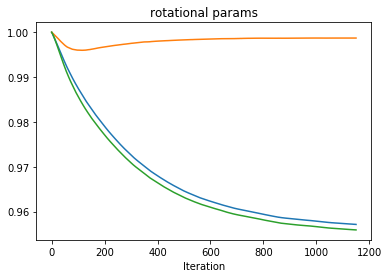

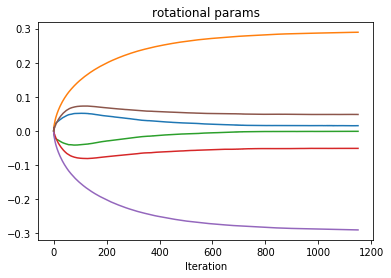

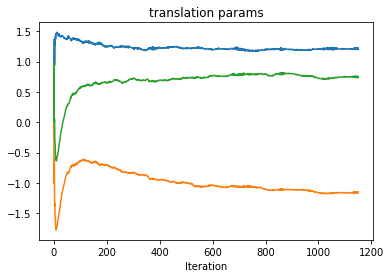

In [81]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.238797293652 0.23876098375
[[ 0.95988987  0.01599257  0.27992085  1.16990232]
 [-0.00155297  0.99865987 -0.05173056 -1.07183643]
 [-0.28037302  0.04922093  0.95862833  0.79604026]]


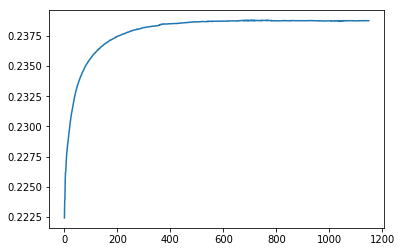

In [82]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

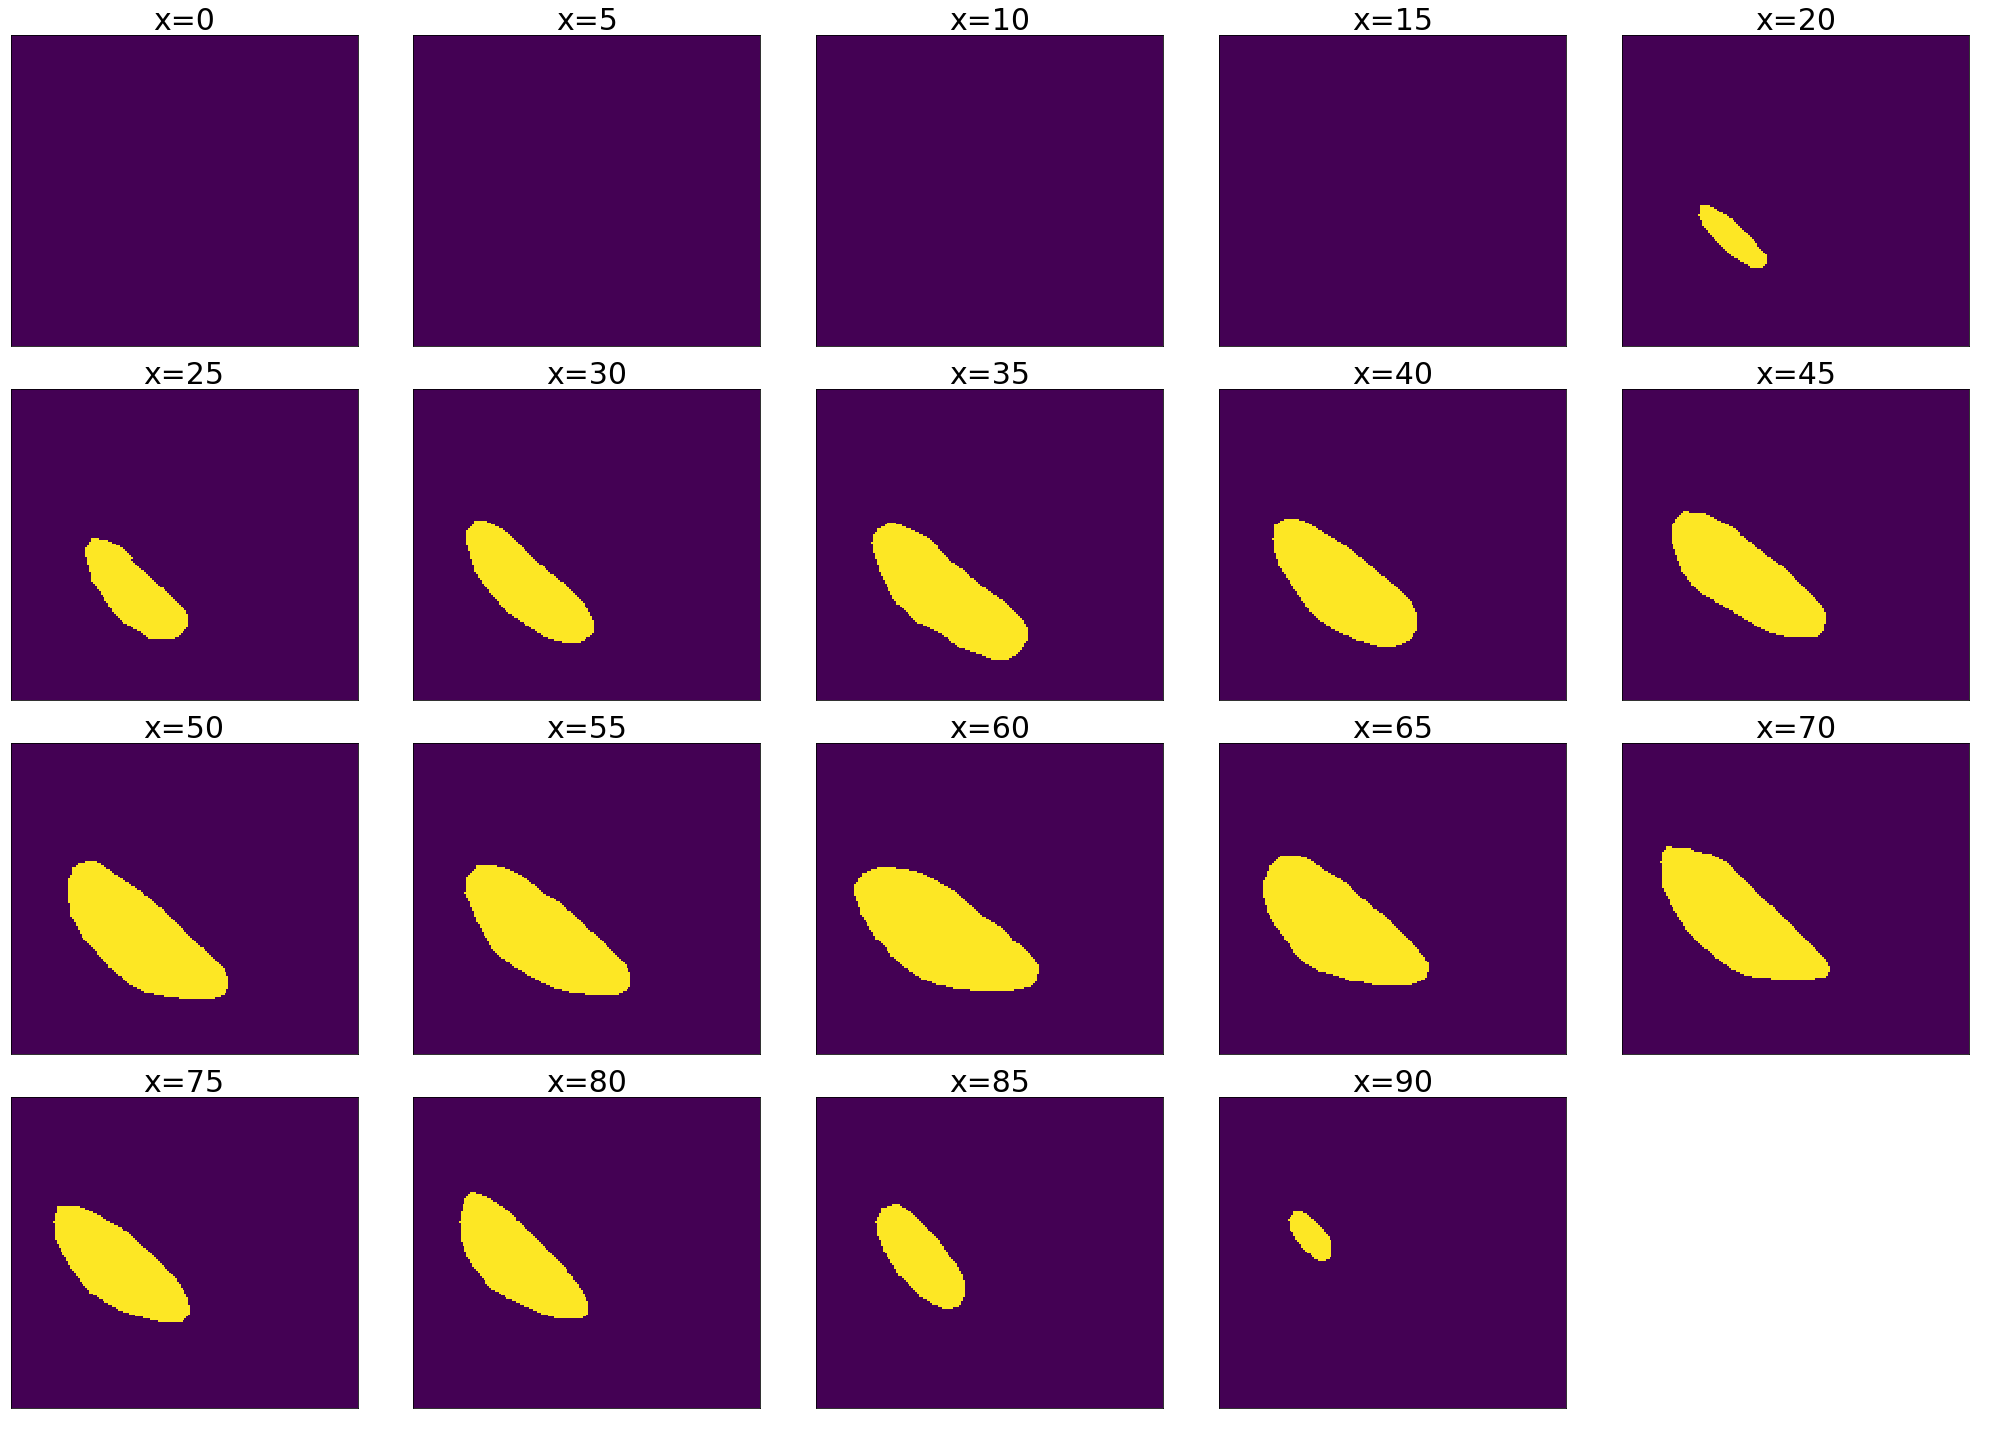

In [83]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [84]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(aligner.Ts[-1], 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [88]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

In [89]:
x1f,x2f,y1f,y2f,z1f,z2f = bbox_3d(volume_fixed[structure_to_label_fixed[structure]])
sf = np.count_nonzero(volume_fixed[structure_to_label_fixed[structure]])

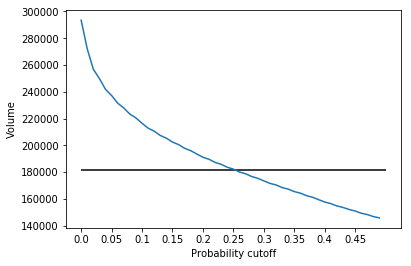

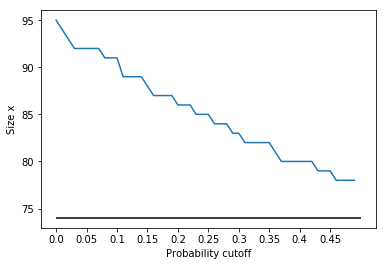

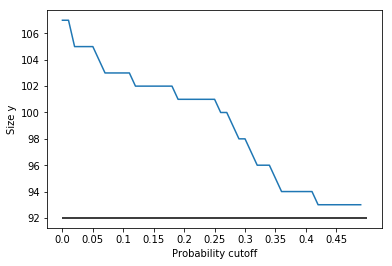

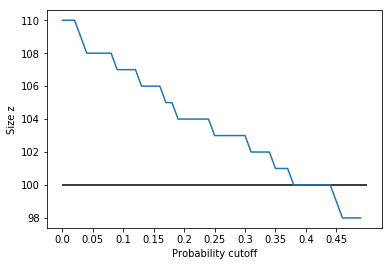

In [90]:
plt.plot([np.count_nonzero(volume_m_alignedTo_f > t) for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=sf, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Volume');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[1] - bbox_3d(volume_m_alignedTo_f > t)[0] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=x2f+1-x1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size x');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[3] - bbox_3d(volume_m_alignedTo_f > t)[2] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=y2f+1-y1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size y');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[5] - bbox_3d(volume_m_alignedTo_f > t)[4] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=z2f+1-z1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size z');
plt.show();

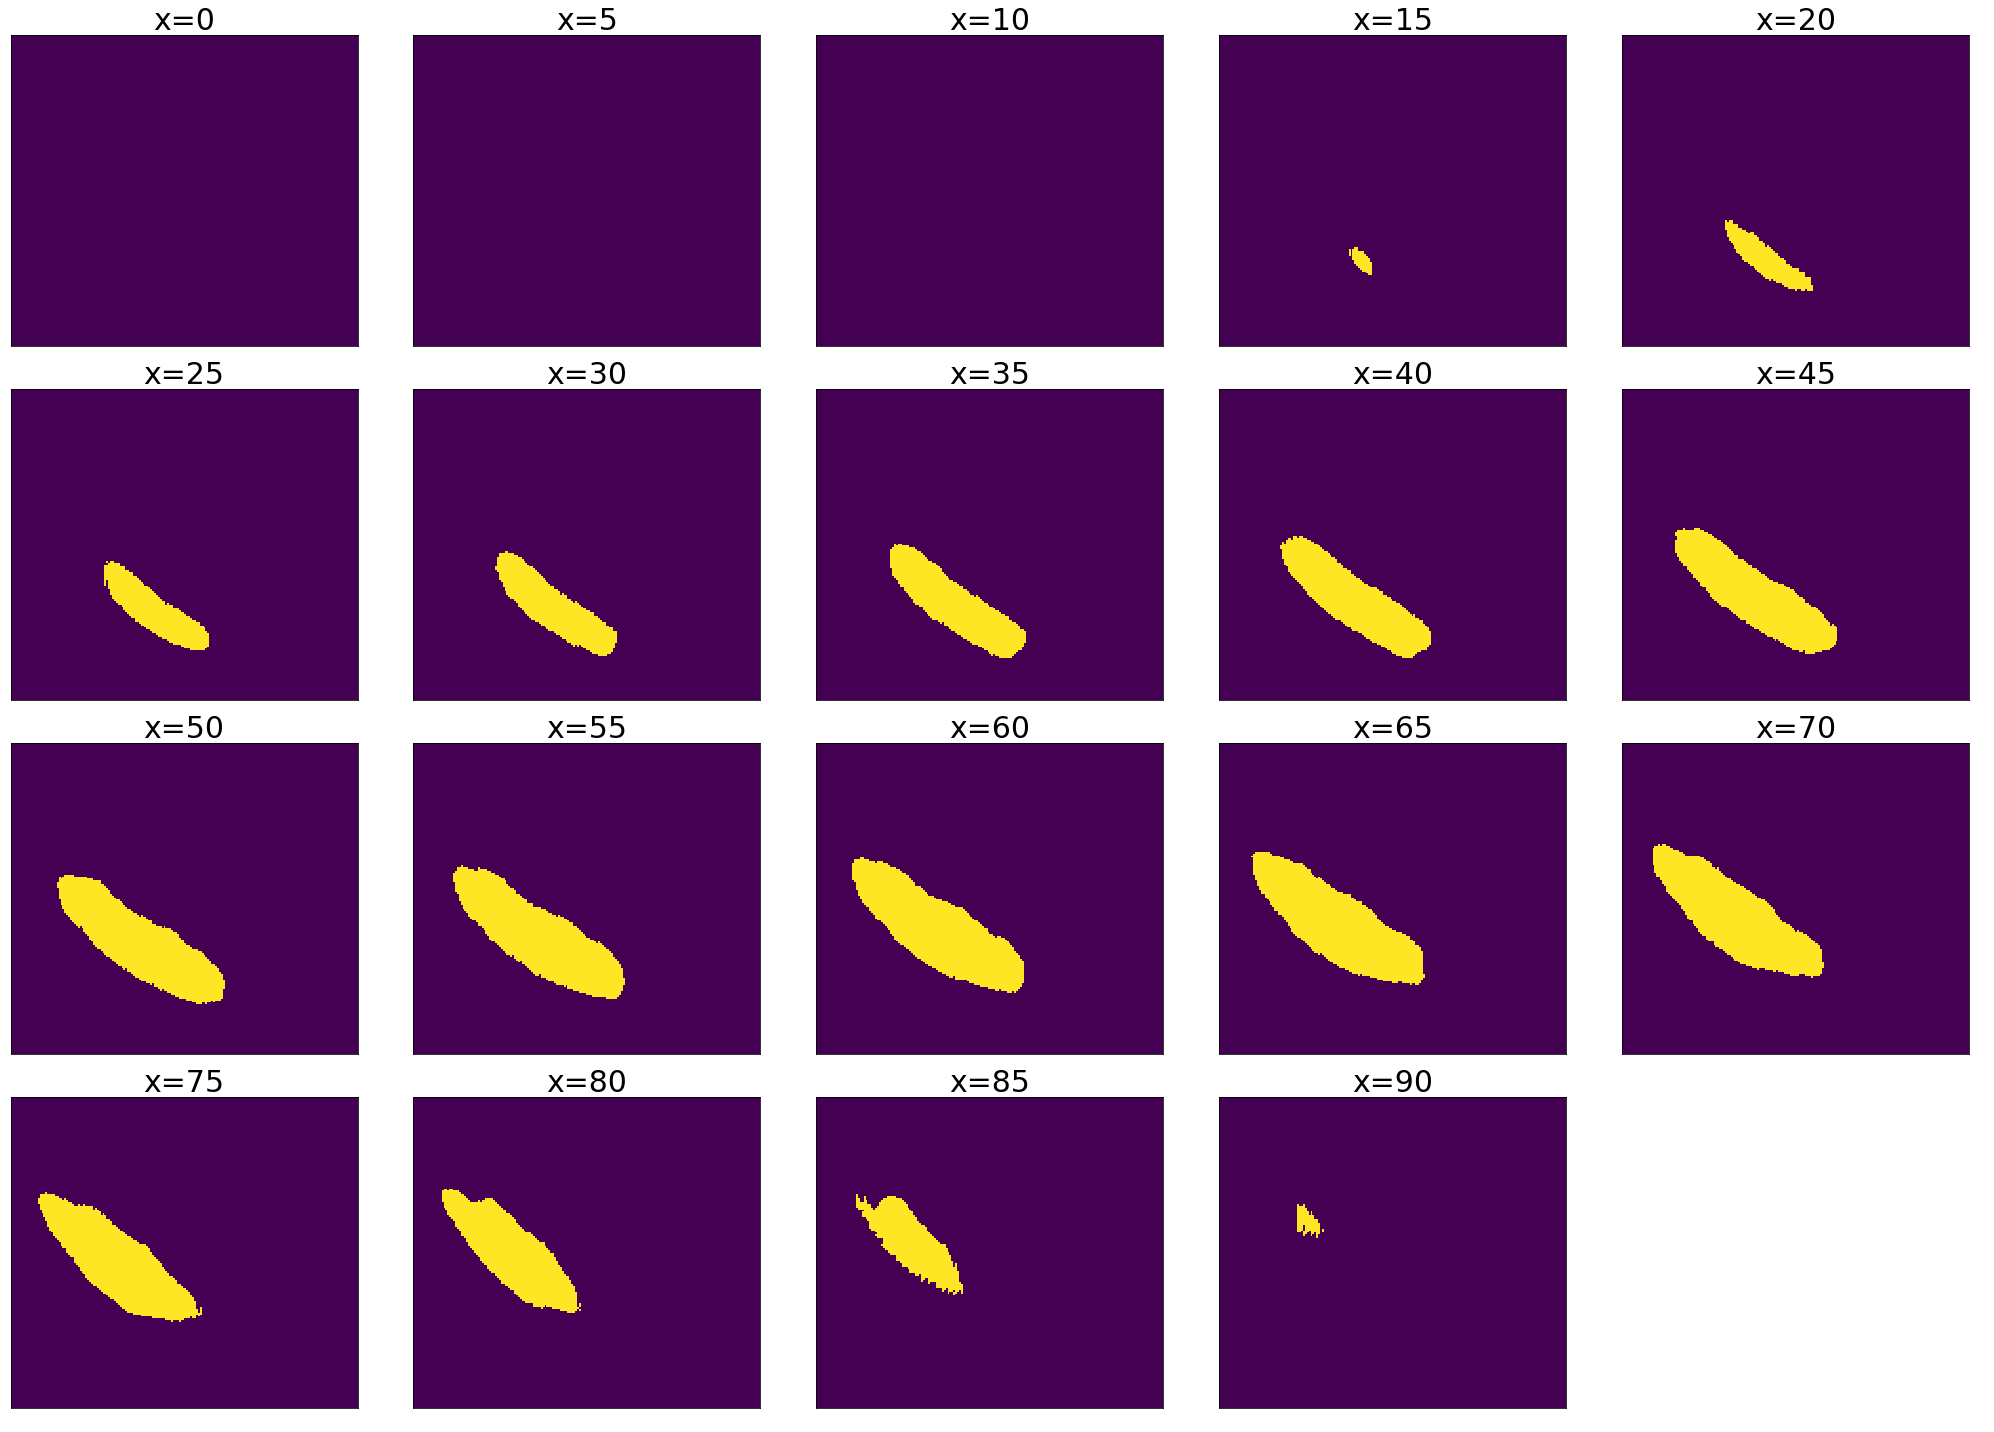

In [91]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f > 0.5, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [92]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32